# 1. load packages, set working directory, read in data and functions

In [ ]:
library(Seurat)
library(monocle)

In [ ]:
dir.create("/lustre/fs4/cao_lab/scratch/zlu/ZL_20210113_sciRate//Intermediate_data/230813_integration_example2")
setwd("/lustre/fs4/cao_lab/scratch/zlu/ZL_20210113_sciRate//Intermediate_data/230813_integration_example2")


In [ ]:
run_Seurat_integration = function(Seu.list,n_pcs = 50,nfeatures=5000,min.dist=0.01,n.neighbors=100){

seu.list <- lapply(X = Seu.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = nfeatures)
})
# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = seu.list)
anchors <- FindIntegrationAnchors(object.list = seu.list, anchor.features = features)
seu.combined <- IntegrateData(anchorset = anchors)
DefaultAssay(seu.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
seu.combined <- ScaleData(seu.combined, verbose = FALSE)
seu.combined <- RunPCA(seu.combined, npcs = n_pcs, verbose = FALSE)
seu.combined <- RunUMAP(seu.combined, reduction = "pca", dims = 1:n_pcs,min.dist = min.dist,return.model = T,
                        n.neighbors = n.neighbors)
seu.combined <- FindNeighbors(seu.combined, reduction = "pca", dims = 1:n_pcs)
seu.combined <- FindClusters(seu.combined, resolution = 0.5)     
seu.combined@meta.data = cbind(seu.combined@meta.data,Embeddings(seu.combined, reduction = "umap"))
return(seu.combined)
}

In [ ]:
##Read in the human and mouse data stored in seurat object
Seu_mouse=readRDS("/lustre/fs4/cao_lab/scratch/zlu/ZL_20210113_sciRate//Intermediate_data/230813_integration_example2/Seu_mouse.rds")
Seu_human=readRDS("/lustre/fs4/cao_lab/scratch/zlu/ZL_20210113_sciRate//Intermediate_data/230813_integration_example2/Seu_human.rds")

In [ ]:
Seu_human@meta.data$dataset='Human'
Seu_mouse@meta.data[which(Seu_mouse@meta.data$EdU=='EdU'),'dataset']='TrackerSci_EdU'
Seu_mouse@meta.data[which(Seu_mouse@meta.data$EdU=='DAPI'),'dataset']='TrackerSci_DAPI'

In [ ]:
##Note: before the analysis, make sure gene names are all capitalized in both human and mouse dataset

# 2. Perform integration analysis

## 2.1 integrate mouse with a subsampled human dataset 

In [ ]:
sample_cell_id <- function(id_list, type_list, target, sample_num) {
        df_tmp = data.frame(id = id_list, type = type_list)
        type_num = nrow(df_tmp %>% filter(type == target))
        if (type_num > sample_num) {
            target_list = df_tmp %>% filter(type == target) %>% 
                sample_n(sample_num)
        }
        else {
            target_list = df_tmp %>% filter(type == target)
        }
        result = as.character(target_list$id)
        return(result)
    }

In [ ]:
##subsample 5000 cells from each main cell type from human dataset
##cell annotations are in the "Main_cluster_name" column
Cluster=Seu_human@meta.data$Main_cluster_name
sample_id=rownames(Seu_human@meta.data)
sample_num=5000
sample_cell_all = sapply(unique(Cluster), function(x) {
        sample_cell_id(sample_id, Cluster, x, sample_num)
    })
cells_selected = unlist(sample_cell_all)

In [ ]:
Seu_human_subsampled = subset(Seu_human,cells = cells_selected )

In [ ]:
Seu.list = list(Seu_human_subsampled,Seu_mouse)

In [ ]:
Seu.combined.subsampled = run_Seurat_integration(Seu.list)

## 2.2 map the rest of human cells to the existing integrative umap space

In [ ]:
Seu_human@meta.data$sample=rownames(Seu_human@meta.data)

In [ ]:
query_cells_id = (Seu_human@meta.data %>% filter(!(sample %in% rownames(Seu_human_subsampled@meta.data))))$sample

In [ ]:
Seu_human_rest = subset(Seu_human,cells=query_cells_id)

In [ ]:
##Map the rest of human cells to the existing integrative umap space
anchors <- FindTransferAnchors(reference = Seu.combined.subsampled, query = Seu_human_rest,
    dims = 1:50, reference.reduction = "pca")
Seu_human_rest <- MapQuery(anchorset = anchors, 
                  reference = Seu.combined.subsampled, 
                  query = Seu_human_rest,
                  refdata = list(celltype = "Main_cluster_name"), 
                  reference.reduction = "pca", 
                  reduction.model = "umap")

In [ ]:
##combine all cells into one seurat object
Seu_combined = merge(Seu.combined.subsampled,Seu_human_rest)
Seu_combined@reductions[['umap']]=CreateDimReducObject(
embeddings = rbind(Seu.combined.subsampled@reductions[['umap']]@cell.embeddings,
      Seu_human_rest@reductions[['ref.umap']]@cell.embeddings))

In [ ]:
saveRDS(Seu_combined,"/lustre/fs4/cao_lab/scratch/zlu/ZL_20210113_sciRate//Intermediate_data/230813_integration_example2/Seu_combined.rds")

# 3. check output

In [1]:
library(Seurat)
library(ggplot2)

Attaching SeuratObject



In [2]:
Seu_combined = readRDS("/lustre/fs4/cao_lab/scratch/zlu/ZL_20210113_sciRate//Intermediate_data/230813_integration_example2/Seu_combined.rds")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



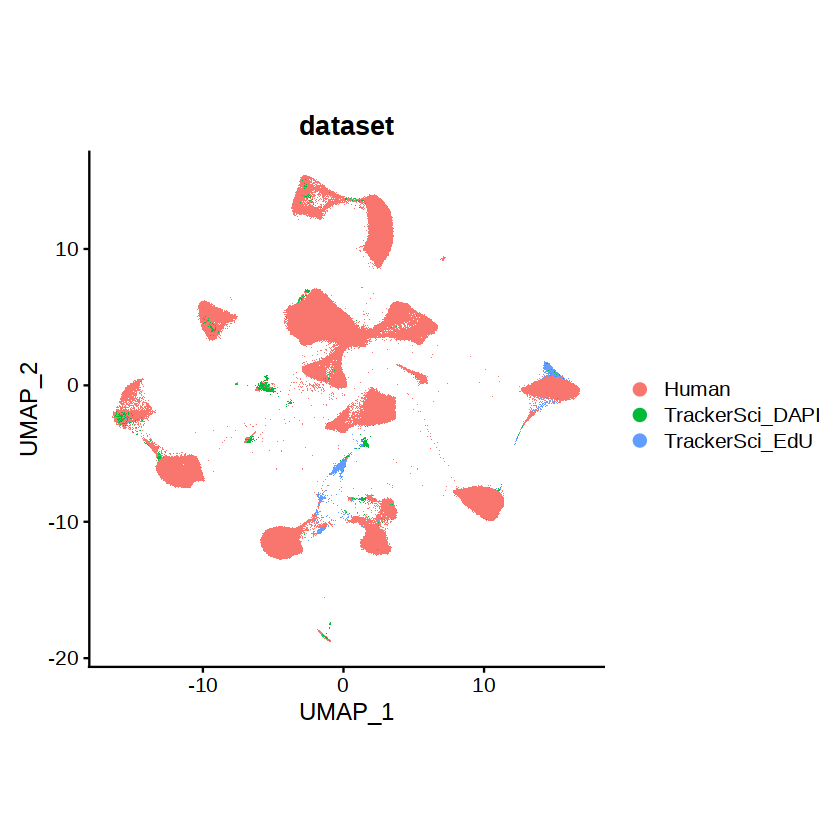

In [3]:
DimPlot(Seu_combined,group.by = 'dataset')+theme(aspect.ratio = 1)